In [1]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img
from nilearn import image
from nilearn import plotting
import argparse
from nilearn.image import new_img_like
import matplotlib.pyplot as plt
from os.path import join


# load and stack images
conduct t-test
convert values back to corr values



In [7]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'pain'
fmri_event = 'stimulus'
beh_regressor = 'expectrating'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task, f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))


In [8]:
remove_sub = [25, 26, 32, 43, 56, 58, 81, 84, 98, 102, 103, 104, 107, 117]
filtered_file_list = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]


In [9]:
len(filtered_file_list)

82

In [10]:
filtered_file_list[0:5]

['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/expectrating/pain/sub-0004_task-pain_corr_x-stimulus_y-expectrating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/expectrating/pain/sub-0038_task-pain_corr_x-stimulus_y-expectrating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/expectrating/pain/sub-0005_task-pain_corr_x-stimulus_y-expectrating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/expectrating/pain/sub-0116_task-pain_corr_x-stimulus_y-expectrating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/expectrating/pain/sub-0053_task-pain_corr_x-stimulus_y-expectrating.nii.gz']

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


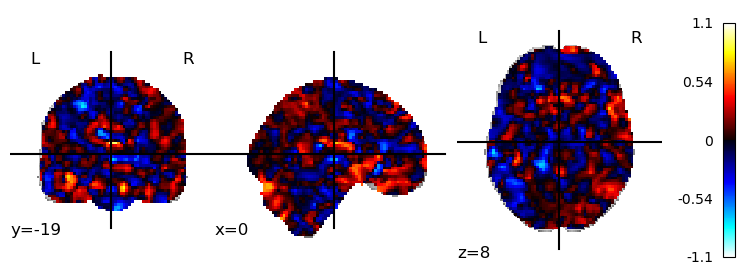

In [11]:
plotting.plot_stat_map(filtered_file_list[0])

In [12]:
concatenated_image = image.concat_imgs(sorted(filtered_file_list))


In [13]:
concatenated_image.get_fdata().shape

(73, 86, 73, 82)

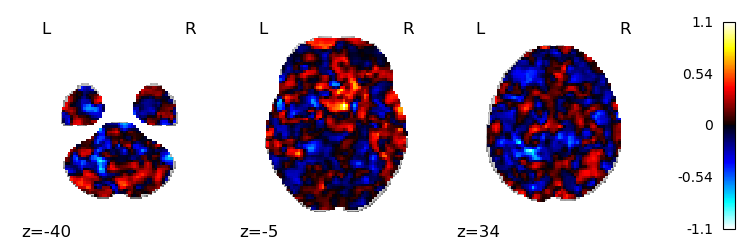

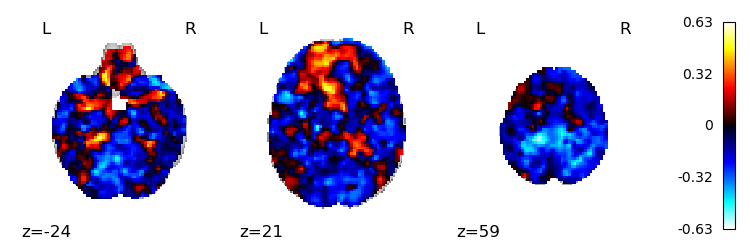

In [14]:
mean1 = image.mean_img(filtered_file_list[0])
mean2 = image.mean_img(filtered_file_list[1])
plotting.plot_stat_map(mean1, display_mode='z', cut_coords=3)
plotting.plot_stat_map(mean2, display_mode='z', cut_coords=3)

mean image

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/find_cuts.py:69: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


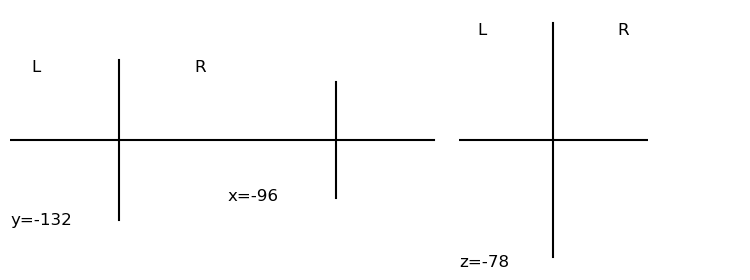

In [15]:
mean_image = image.mean_img(concatenated_image)
plotting.plot_stat_map(mean_image)

# mask images

In [16]:
# imgfname = join(main_dir, f'analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-{fmri_event}_trial-011_cuetype-low_stimintensity-low.nii.gz')
# ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
first_image = image.index_img(concatenated_image, 0)
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = first_image.affine, target_shape = first_image.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = first_image.affine, target_shape = first_image.shape, 
                    memory="nilearn_cache", memory_level=1)

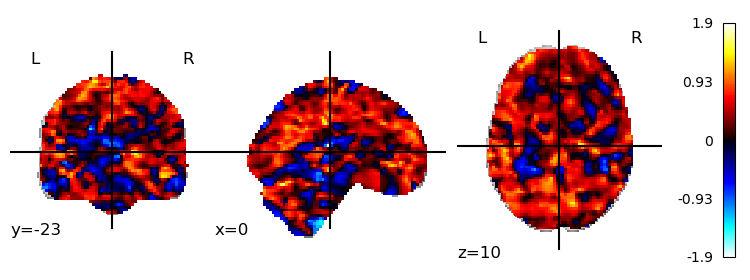

In [17]:
plotting.plot_stat_map(first_image)


In [18]:
fmri_masked = nifti_masker.fit_transform(concatenated_image)

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:542: UserWarning: Persisting input arguments took 1.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


In [19]:
fmri_masked.shape

(82, 98053)

In [20]:
meanval = np.nanmean(fmri_masked, axis = 0)

In [21]:
meanval.shape

(98053,)

(array([   75.,   786.,  2487.,  8129., 21806., 33905., 22481.,  6856.,
         1356.,   172.]),
 array([-0.12982339, -0.10964415, -0.08946492, -0.06928568, -0.04910645,
        -0.02892722, -0.00874798,  0.01143125,  0.03161048,  0.05178972,
         0.07196895]),
 <BarContainer object of 10 artists>)

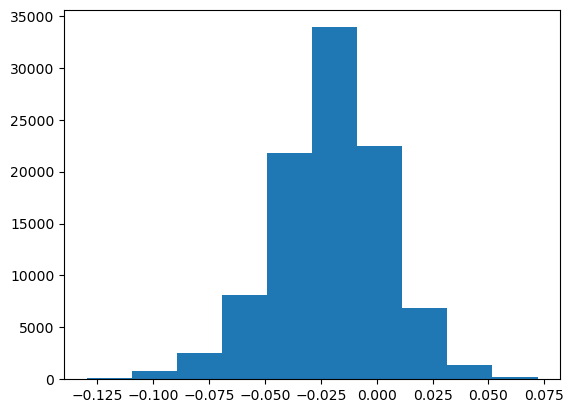

In [22]:
plt.hist(meanval)

# ttest

In [23]:
fmri_masked.shape

(82, 98053)

In [24]:
tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

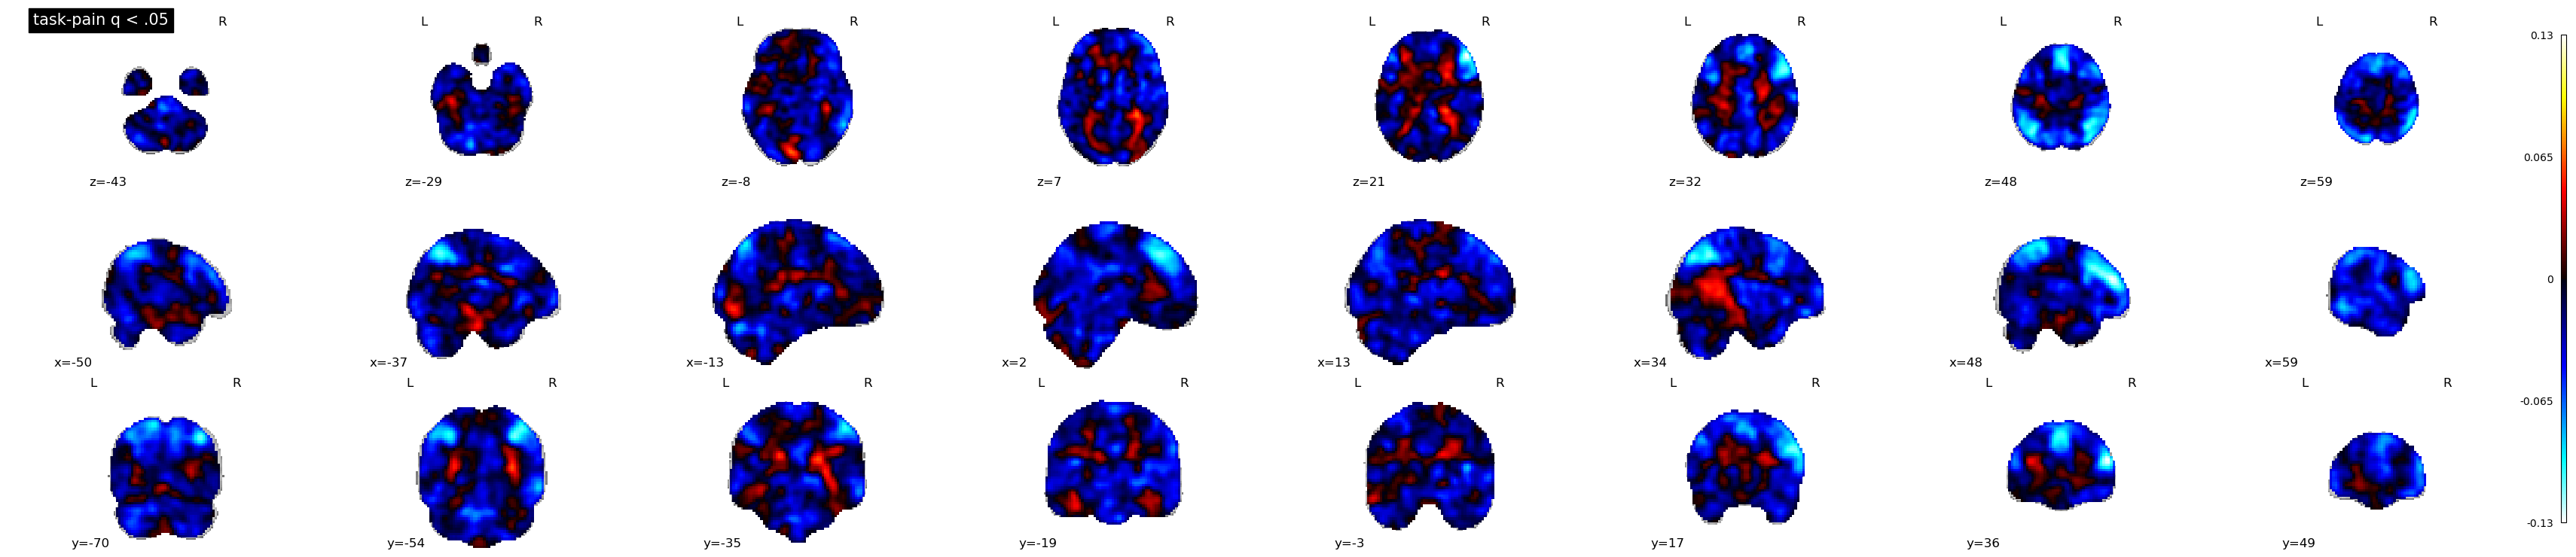

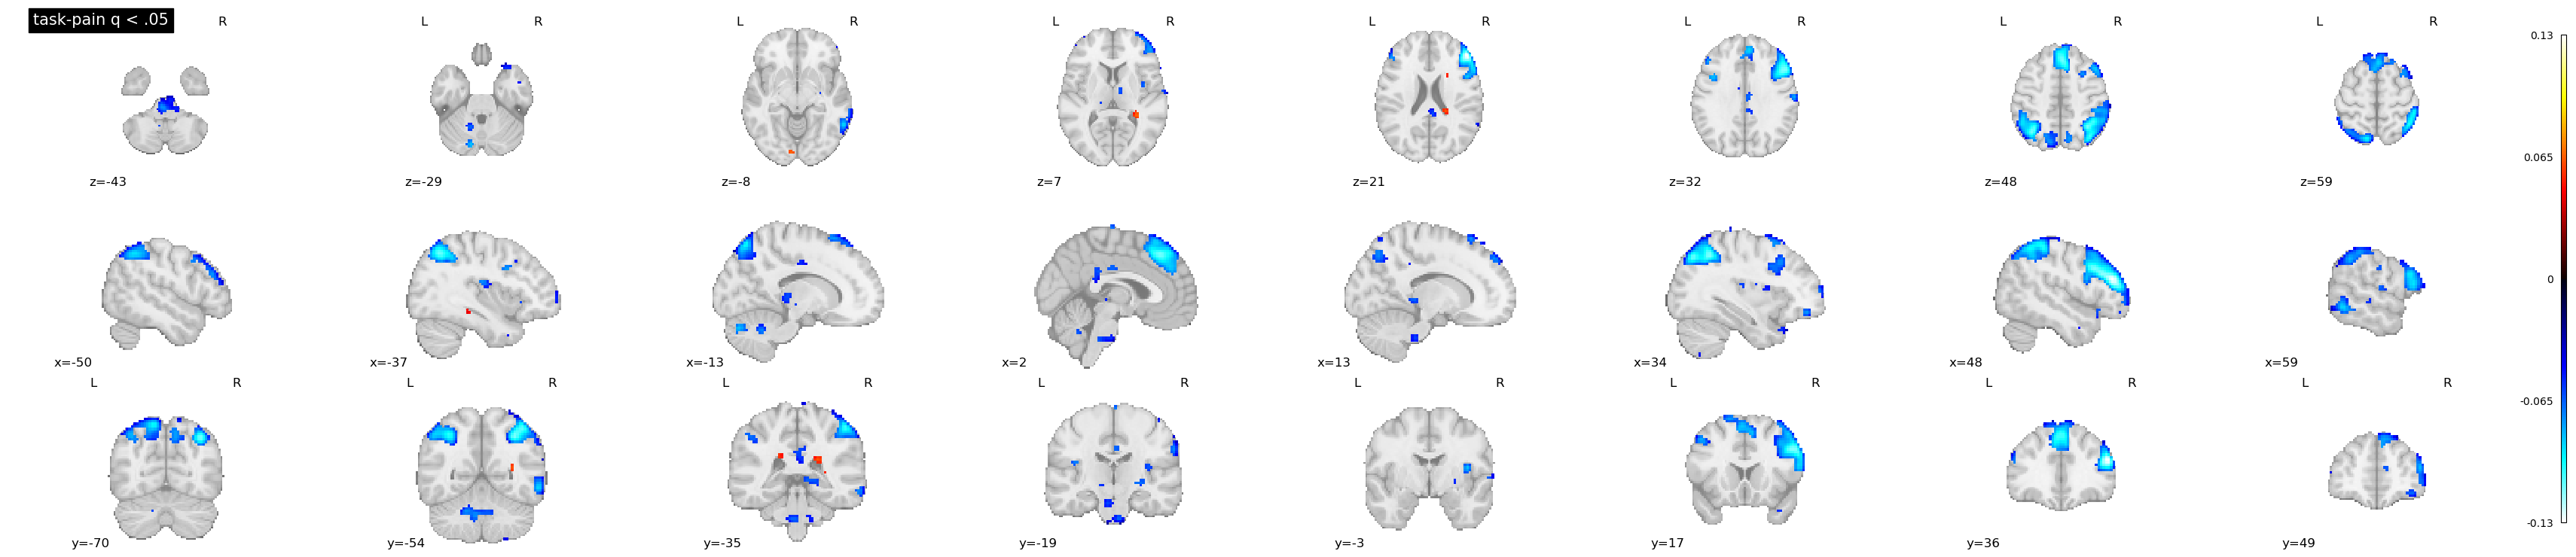

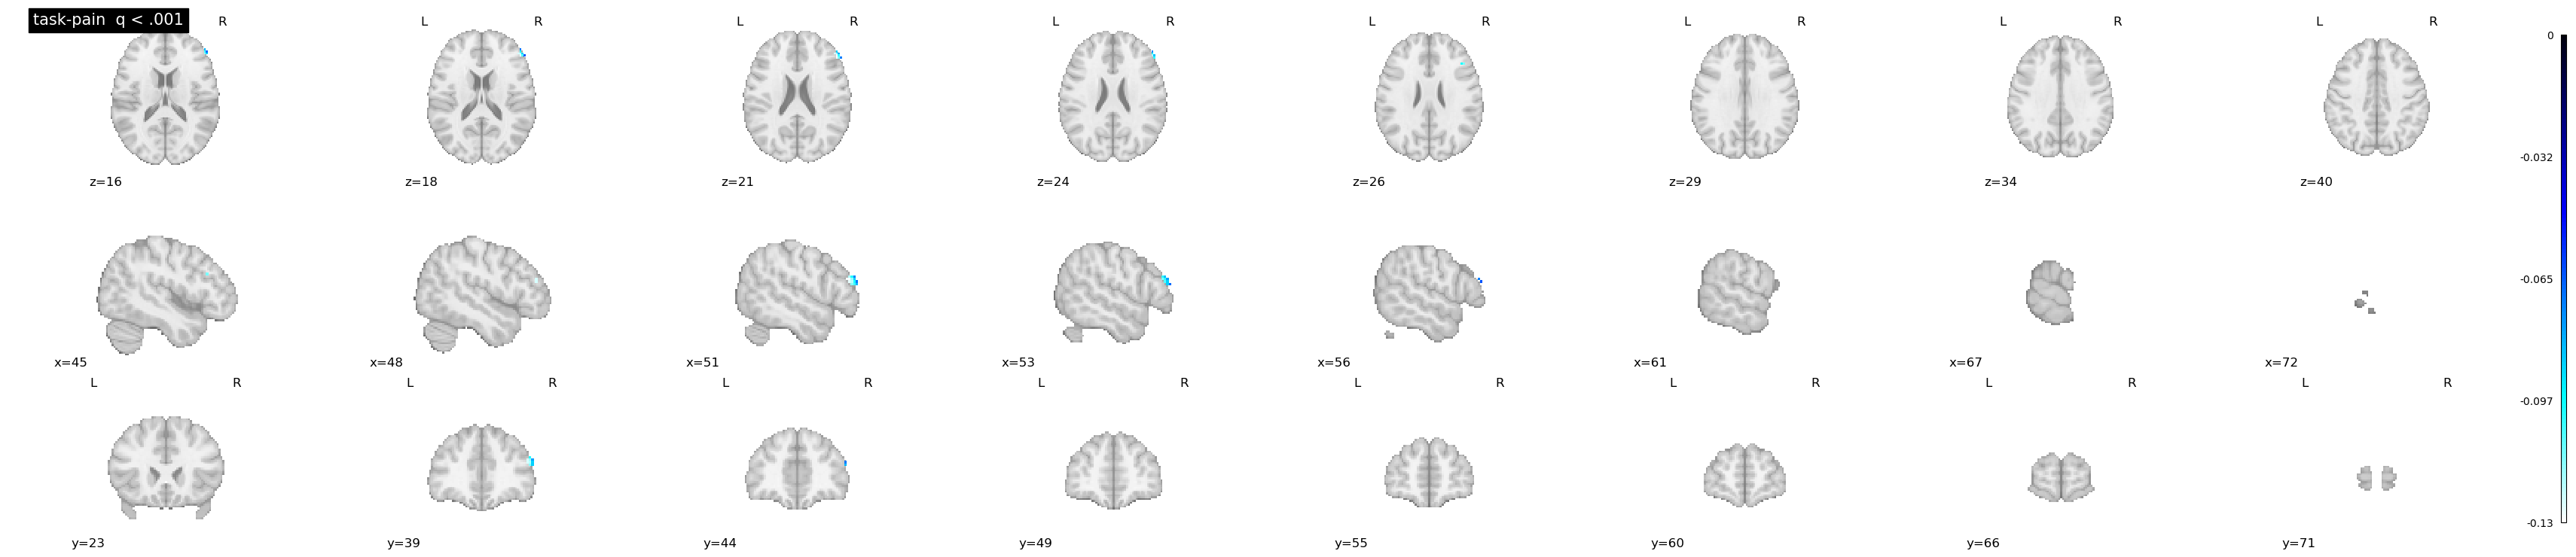

In [25]:
# tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
# reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked, axis = 0))
                     
# map 1
con_t = nifti_masker.inverse_transform(tanhcorr_t)

# map 2
result_mapp = np.zeros(fmri_masked.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
con_tmapp = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
con_tmap_001p = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(con_t,  display_mode = 'mosaic', title = 'task-pain q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = 'task-pain q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = 'task-pain  q < .001', cut_coords = 8)

# vicarious

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:542: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


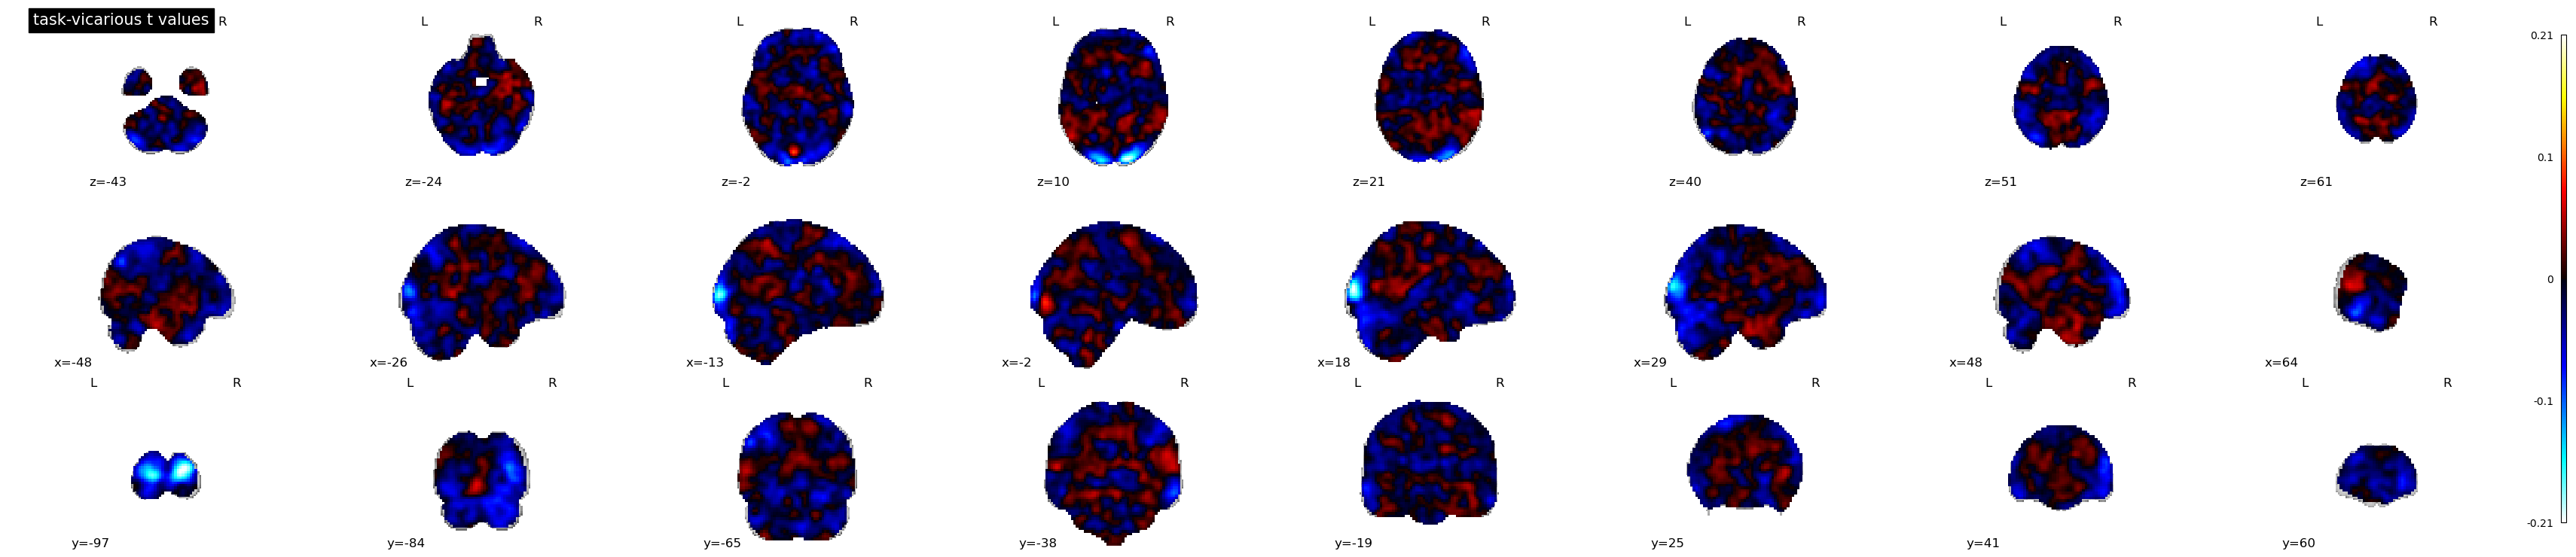

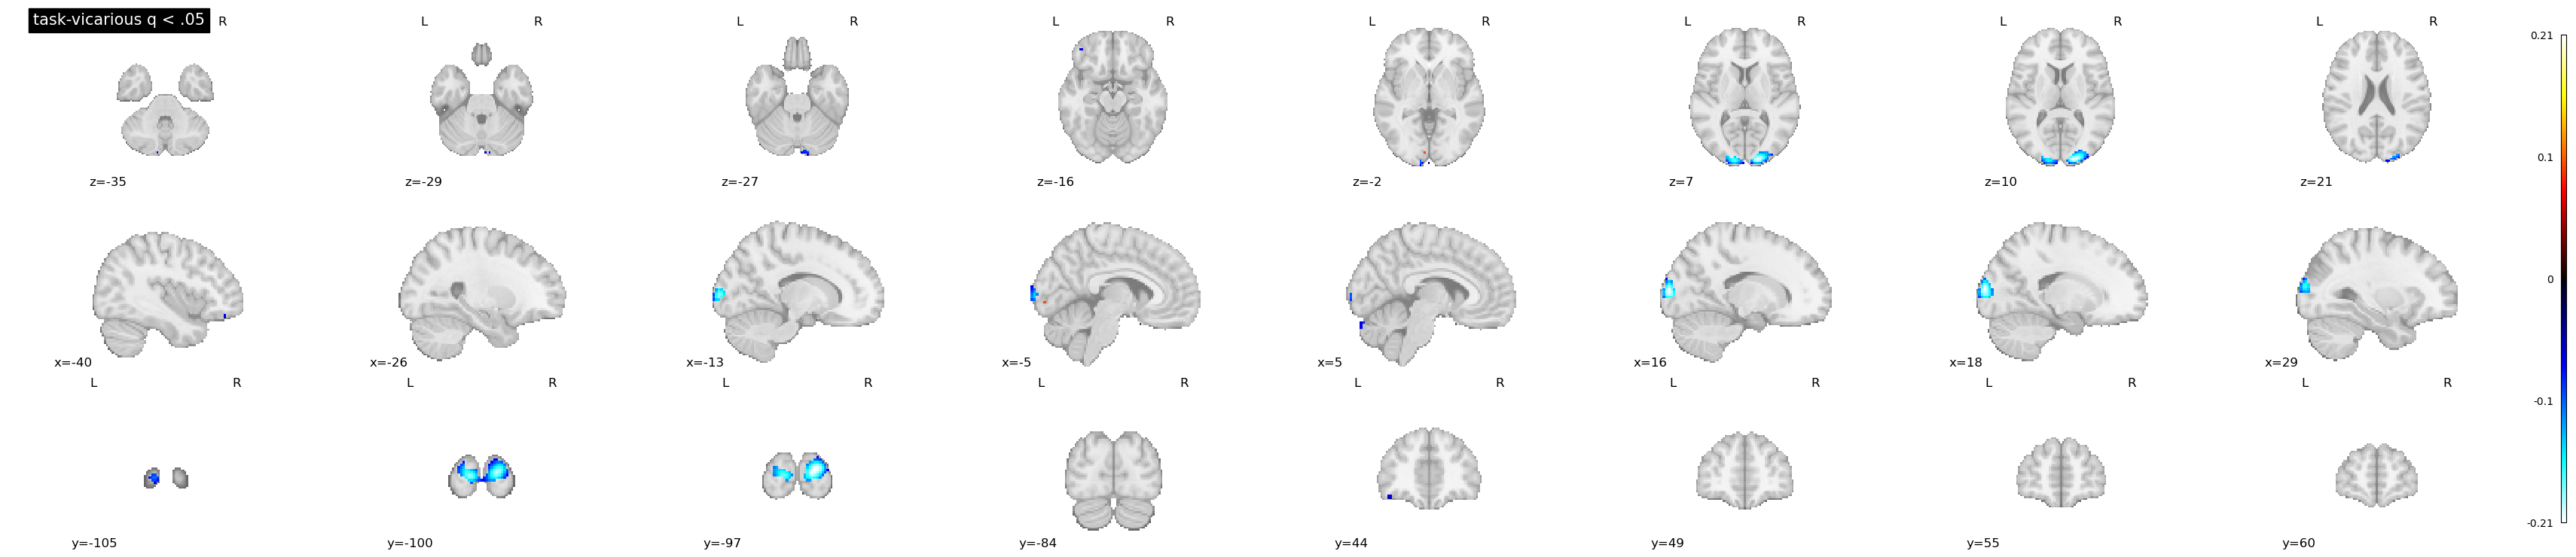

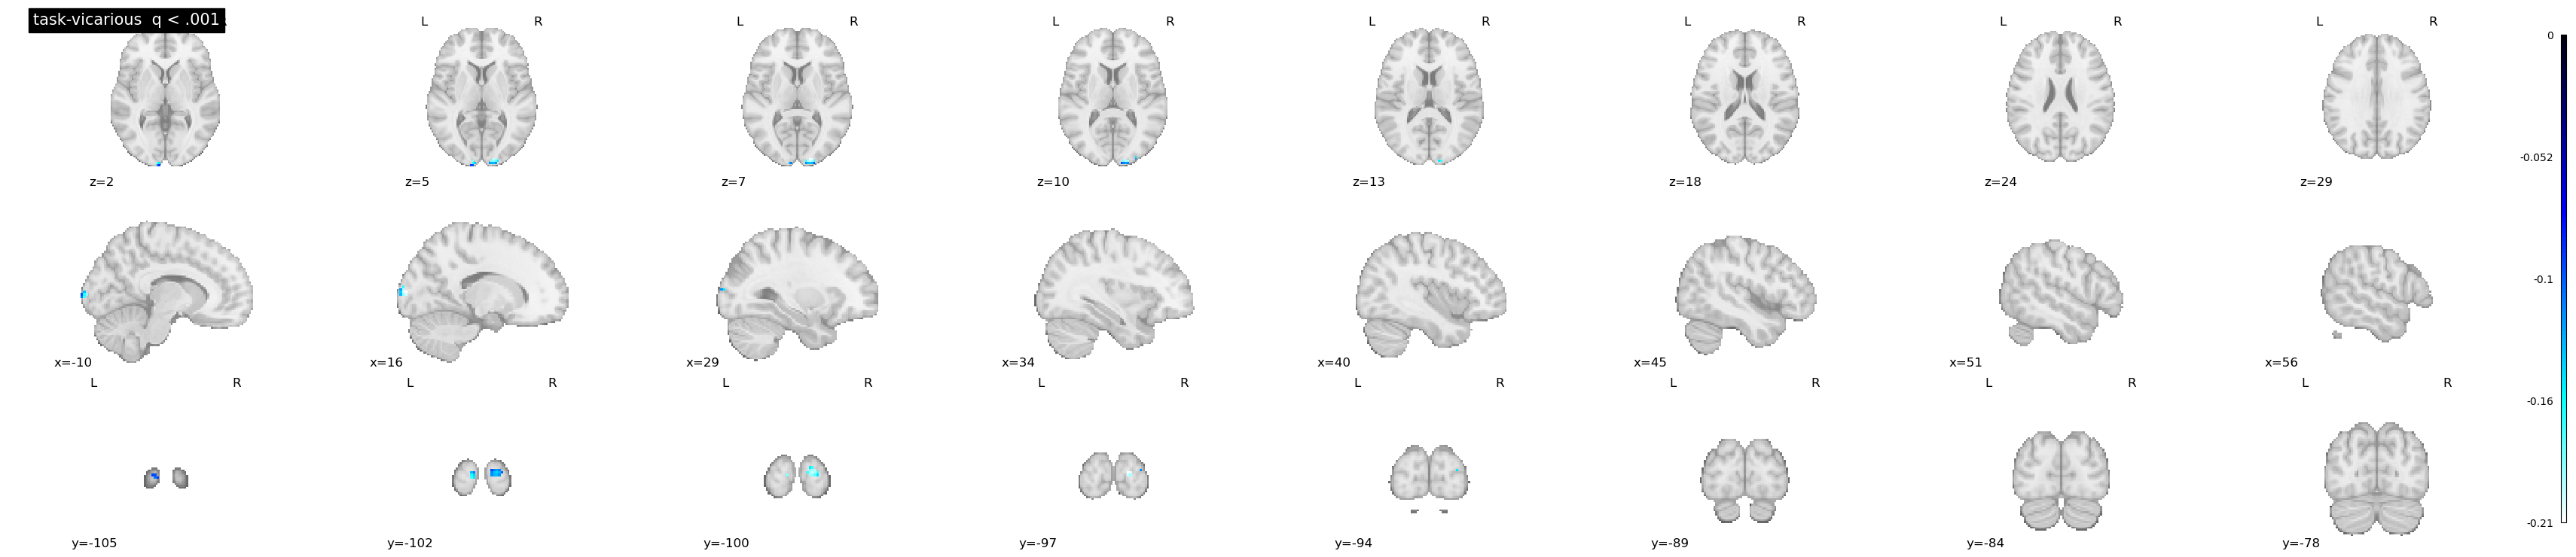

In [26]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'vicarious'
fmri_event = 'stimulus'
beh_regressor = 'expectrating'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task, f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

remove_sub = [1]
filtered_file_list = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]

# stack all files into a 4d nifti
concatenated_image = image.concat_imgs(sorted(filtered_file_list))
fmri_masked = nifti_masker.fit_transform(concatenated_image)

tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked, axis = 0))
                     
# map 1
con_t = nifti_masker.inverse_transform(tanhcorr_t)

# map 2
result_mapp = np.zeros(fmri_masked.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
con_tmapp = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
con_tmap_001p = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(con_t,  display_mode = 'mosaic', title = f'task-{task} t values', cut_coords = 8)
plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = f'task-{task} q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = f'task-{task}  q < .001', cut_coords = 8)

# cognitive

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:542: UserWarning: Persisting input arguments took 0.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


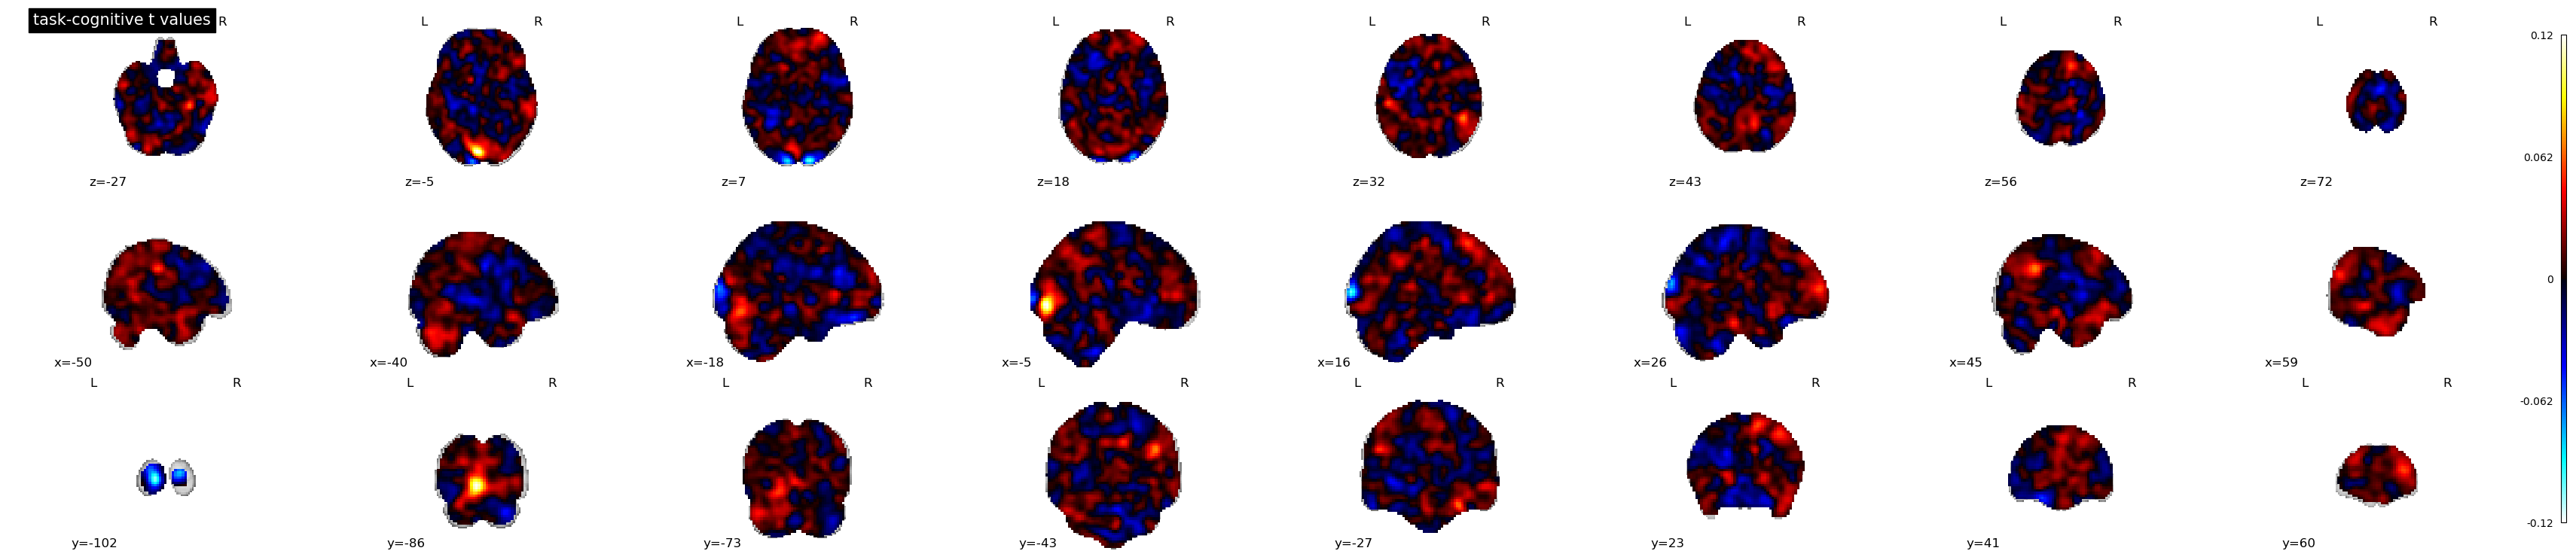

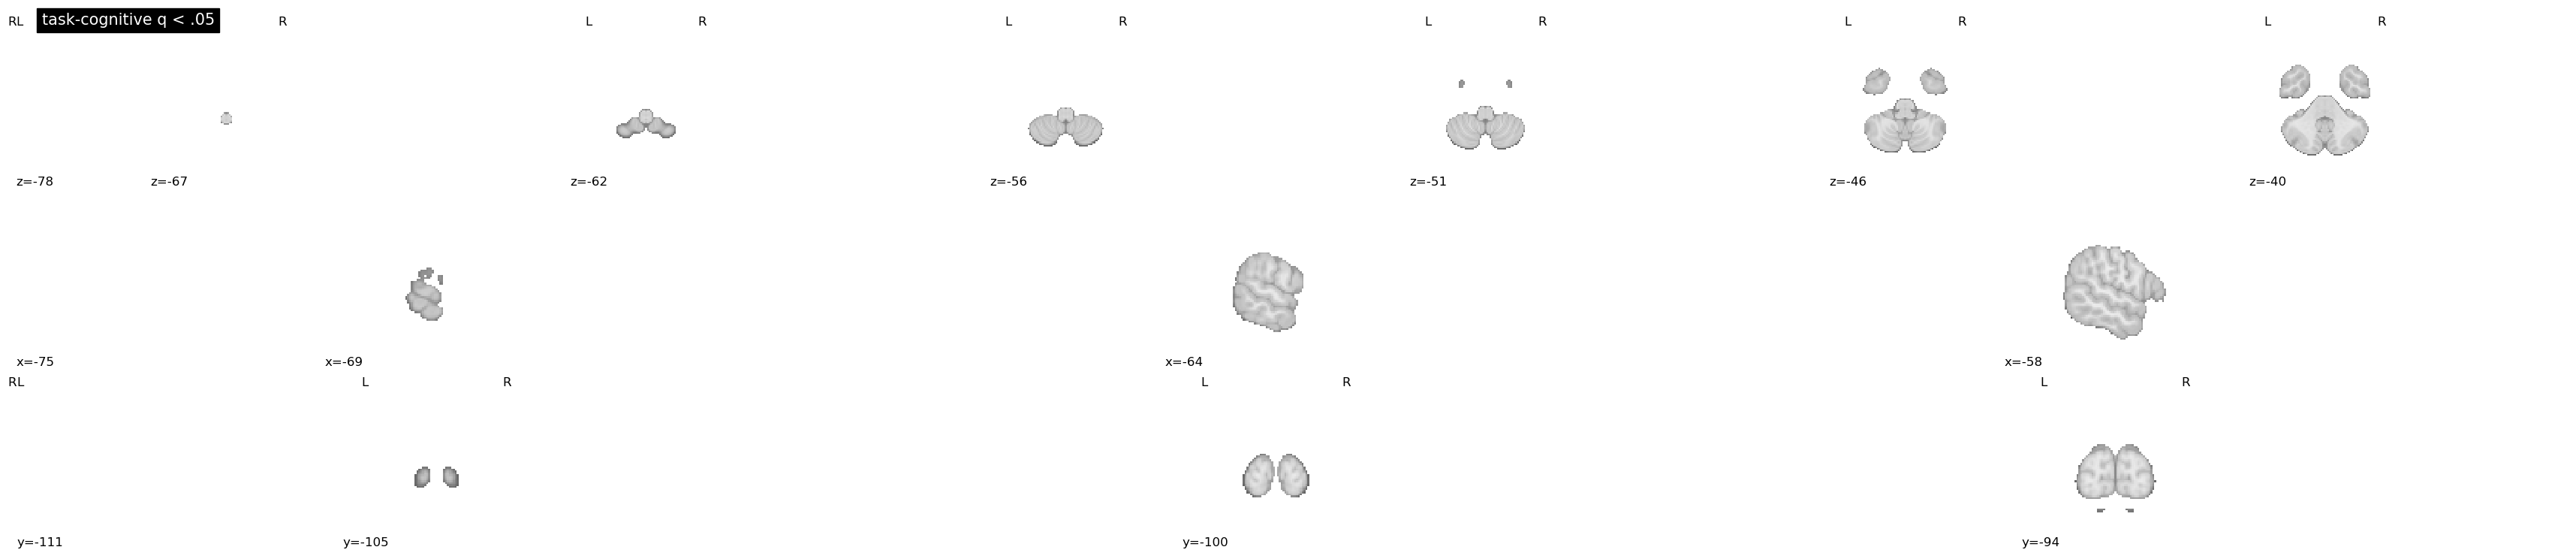

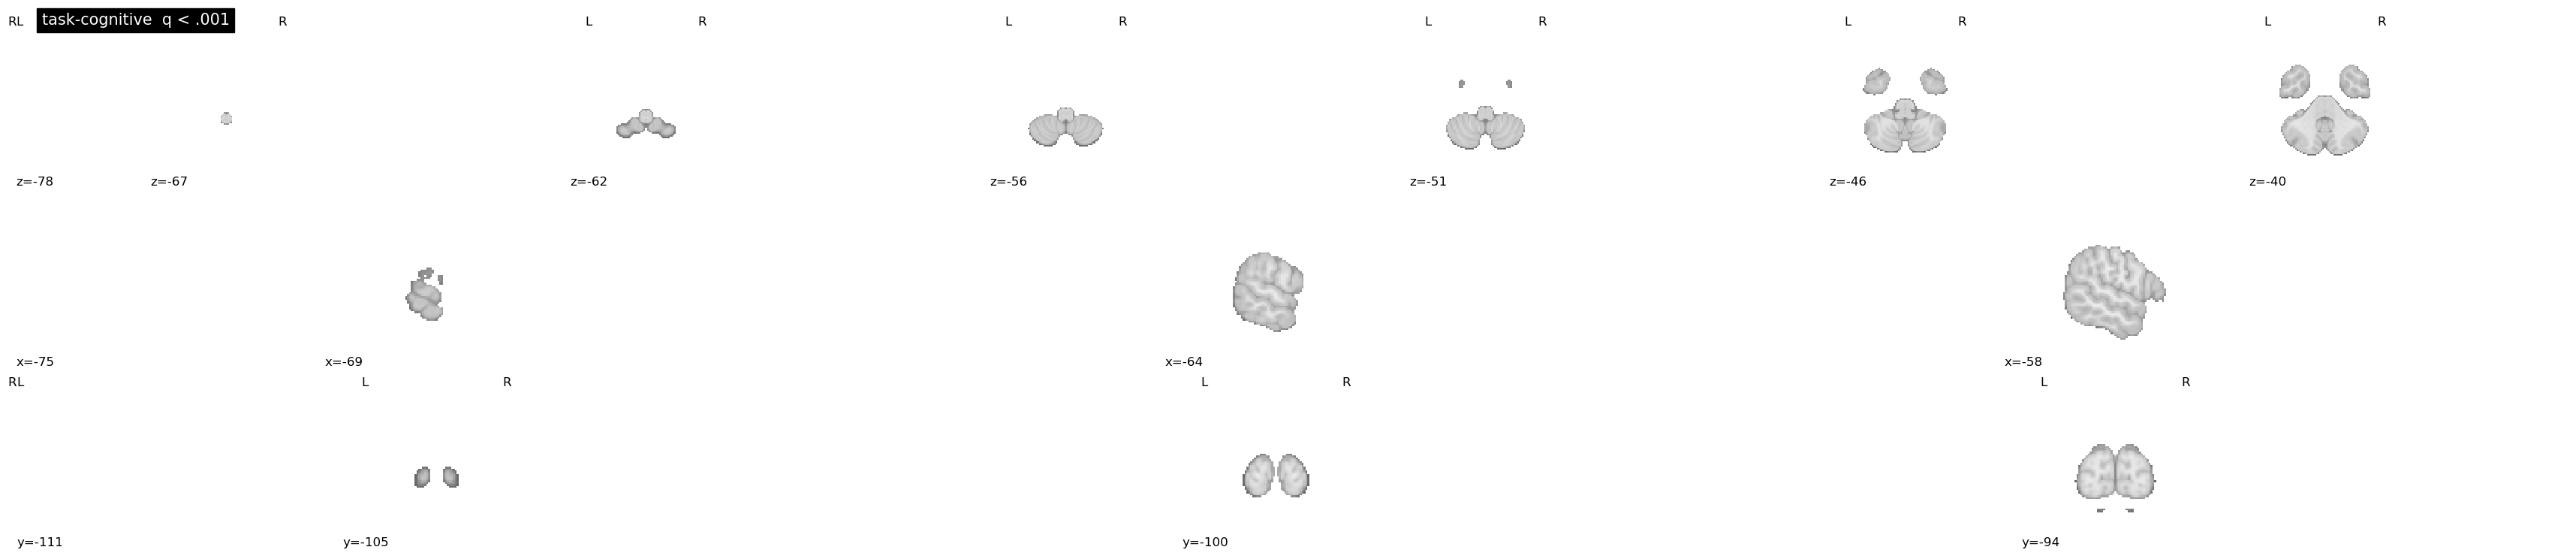

In [27]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'cognitive'
fmri_event = 'stimulus'
beh_regressor = 'expectrating'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task, f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

remove_sub = [1]
filtered_file_list = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]

# stack all files into a 4d nifti
concatenated_image = image.concat_imgs(sorted(filtered_file_list))
fmri_masked = nifti_masker.fit_transform(concatenated_image)

tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked, axis = 0))
                     
# map 1
con_t = nifti_masker.inverse_transform(tanhcorr_t)

# map 2
result_mapp = np.zeros(fmri_masked.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
con_tmapp = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
con_tmap_001p = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(con_t,  display_mode = 'mosaic', title = f'task-{task} t values', cut_coords = 8)
plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = f'task-{task} q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = f'task-{task}  q < .001', cut_coords = 8)